In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 100)

mpl.rc(group='figure', figsize=(10,8))
plt.style.use('seaborn')

In [448]:
X_pumps = pd.read_csv('https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv')
print(f'X_pumps: {X_pumps.shape}')

y_pumps = pd.read_csv('https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')
print(f'y_pumps: {y_pumps.shape}')

X_test = pd.read_csv('https://s3.amazonaws.com/drivendata/data/7/public/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv')
print(f'X_test: {X_test.shape}')

X_pumps: (59400, 40)
y_pumps: (59400, 2)
X_test: (14850, 40)


## Training dataset
* Several features have missing values (e.g. funder, installer, etc)
* Most features are categorical
* One spatial feature (latitude, longitude)

In [5]:
X_pumps.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [9]:
X_pumps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

## Training dataset labels
* Only a small portion (~7.3%) are "functional needs repair".

In [26]:
y_pumps.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [10]:
y_pumps.status_group.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

## Combine the train dataset and test dataset to make it easier to analyze

In [449]:
train_dataset = 0
test_dataset = 1

# Add dataset attribute to make it easier to determine from which dataset the records originated
X_pumps['dataset'] = train_dataset
X_test['dataset'] = test_dataset

X_combined = pd.concat([X_pumps, X_test], ignore_index=False, axis=0)

print(f'X_combined: {X_combined.shape}')

X_combined: (74250, 41)


In [409]:
'''
features = ['longitude', 'latitude', 'amount_tsh', 'funder', 'gps_height', 'installer', 
            'wpt_name', 'num_private','basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
            'ward', 'population', 'public_meeting', 'recorded_by','scheme_management', 'scheme_name', 'permit', 
            'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class',
            'management', 'management_group', 'payment', 'payment_type','water_quality', 'quality_group', 
            'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 
            'waterpoint_type_group', 'date_recorded', 
           ]
''';

# Feature Analysis
* histograms
* scatter plots
* aggregation

## Latitude and Longitude
* Some pumps with latitude and longitude values close to 0
* Need to treat the latitude and longitude values close to 0 in the datasets as missing values
* 138 records in train dataset with the same latitude/longitude as another record
* 8 records in train dataset with the same latitude/longitude as another record

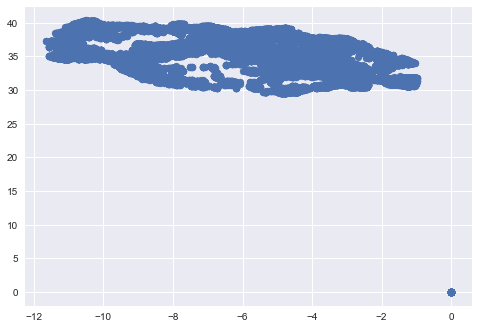

In [69]:
plt.scatter(x=X_combined.latitude, y=X_combined.longitude);

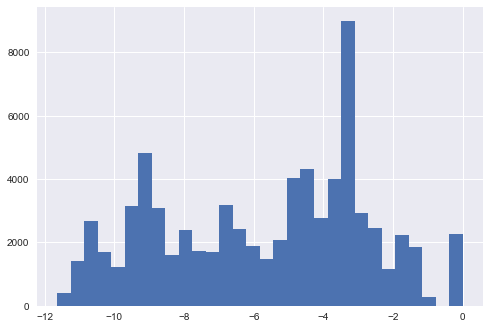

In [70]:
X_combined.latitude.hist(bins=30)

In [71]:
X_combined.latitude[X_combined.latitude > -1.0].value_counts().sort_index()

-9.995223e-01       1
-9.995065e-01       1
-9.994692e-01       1
-9.991170e-01       1
-9.990121e-01       1
-9.989160e-01       1
-9.987523e-01       1
-9.984644e-01       1
-2.000000e-08    2269
Name: latitude, dtype: int64

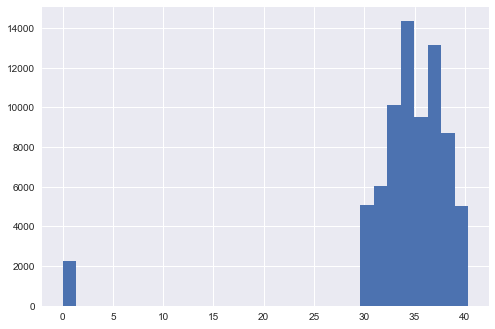

In [72]:
X_combined.longitude.hist(bins=30)

In [73]:
X_combined.longitude[X_combined.longitude < 1.0].value_counts().sort_index()

0.0    2269
Name: longitude, dtype: int64

In [450]:
X_pumps.loc[X_pumps.latitude > -0.9, 'latitude'] = np.NaN
X_pumps.loc[X_pumps.longitude < 1.0, 'latitude'] = np.NaN

In [451]:
X_test.loc[X_test.latitude > -0.9, 'latitude'] = np.NaN
X_test.loc[X_test.longitude < 1.0, 'latitude'] = np.NaN

In [452]:
X_combined.loc[X_combined.latitude > -0.9, 'latitude'] = np.NaN
X_combined.loc[X_combined.longitude < 1.0, 'latitude'] = np.NaN

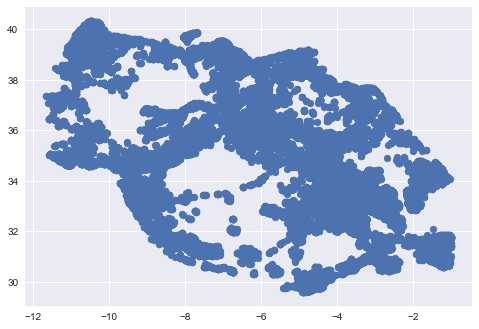

In [75]:
plt.scatter(x=X_combined.latitude, y=X_combined.longitude);

In [459]:
ll = X_pumps.groupby(['latitude', 'longitude'])
ll = ll.filter(lambda x: len(x) > 1)
print(f'{ll.shape[0]} duplicate records in train dataset')

138 duplicate records in train dataset


In [460]:
ll = X_test.groupby(['latitude', 'longitude'])
ll = ll.filter(lambda x: len(x) > 1)
print(f'{ll.shape[0]} duplicate records in test dataset')

8 duplicate records in test dataset


# Geographic area features appear to fall more or less into the following hierarchy
* basin
* region
* region_code
* district
* lga
* ward 
* subvillage

## Basin

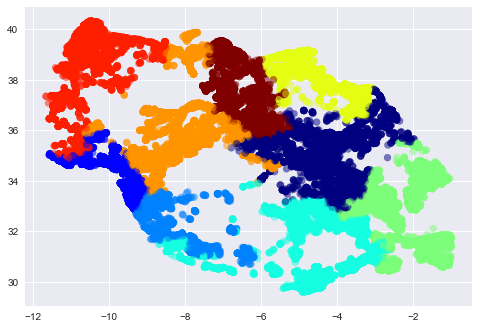

In [76]:
basin = X_combined.basin.astype('category')

plt.scatter(x=X_combined.latitude, y=X_combined.longitude, 
           c=basin.cat.codes, cmap='jet', alpha=0.5);

In [77]:
basin.value_counts(dropna=False).sort_index()

Internal                    9642
Lake Nyasa                  6332
Lake Rukwa                  3059
Lake Tanganyika             8052
Lake Victoria              12871
Pangani                    11143
Rufiji                      9987
Ruvuma / Southern Coast     5587
Wami / Ruvu                 7577
Name: basin, dtype: int64

## Region

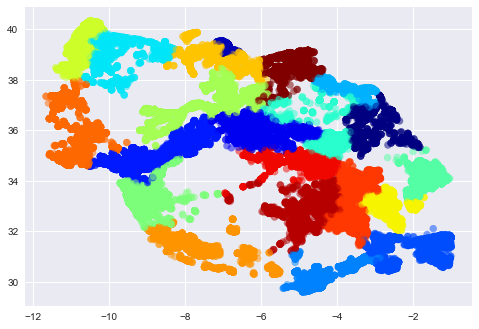

In [423]:
region = X_combined.region.astype('category')

plt.scatter(x=X_combined.latitude, y=X_combined.longitude, 
           c=region.cat.codes, cmap='jet', alpha=0.5);

In [79]:
region.value_counts(dropna=False).sort_index()

Arusha           4111
Dar es Salaam    1020
Dodoma           2779
Iringa           6599
Kagera           4174
Kigoma           3533
Kilimanjaro      5494
Lindi            1920
Manyara          1972
Mara             2451
Mbeya            5758
Morogoro         5038
Mtwara           2144
Mwanza           3897
Pwani            3331
Rukwa            2242
Ruvuma           3306
Shinyanga        6293
Singida          2536
Tabora           2466
Tanga            3186
Name: region, dtype: int64

## Region Code

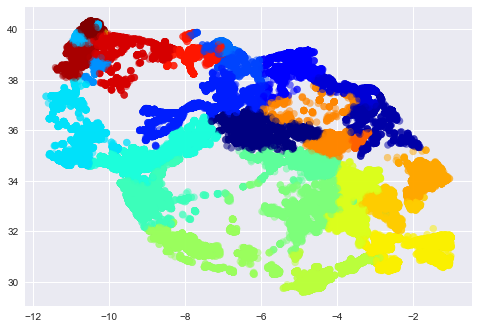

In [463]:
region = X_combined.region_code.astype('category')

plt.scatter(x=X_combined.latitude, y=X_combined.longitude, 
           c=region.cat.codes, cmap='jet', alpha=0.5);

In [464]:
region.value_counts(dropna=False).sort_index()

1     2779
2     3709
3     5494
4     3145
5     5079
6     2032
7     1020
8      375
9      499
10    3306
11    6608
12    5759
13    2536
14    2488
15    2242
16    3533
17    6334
18    4183
19    3824
20    2451
21    1972
24     402
40       1
60    1298
80    1536
90    1133
99     512
Name: region_code, dtype: int64

## District

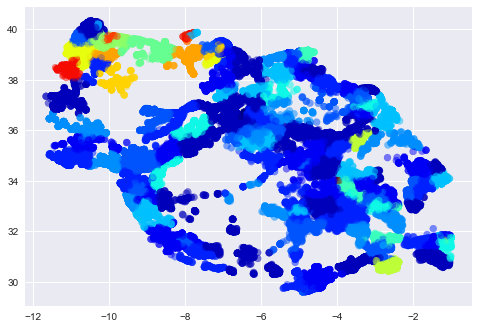

In [80]:
district = X_combined.district_code.astype('category')

plt.scatter(x=X_combined.latitude, y=X_combined.longitude, 
           c=district.cat.codes, cmap='jet', alpha=0.5);

In [81]:
district.value_counts(dropna=False).sort_index()

0        27
1     15299
2     13929
3     12521
4     11253
5      5428
6      5108
7      4166
8      1282
13      496
23      360
30     1256
33     1063
43      653
53      921
60       76
62      127
63      264
67        8
80       13
Name: district_code, dtype: int64

## LGA
* No missing values
* 120+ unique values

In [178]:
X_combined.lga.isnull().sum()

0

In [168]:
len(X_combined.lga.unique())

125

In [180]:
print(X_combined.lga.value_counts().head())
print('\n')
print(X_combined.lga.value_counts().tail())

Njombe          3128
Moshi Rural     1566
Arusha Rural    1521
Bariadi         1485
Rungwe          1381
Name: lga, dtype: int64


Moshi Urban     103
Kigoma Urban     95
Arusha Urban     82
Lindi Urban      24
Nyamagana         2
Name: lga, dtype: int64


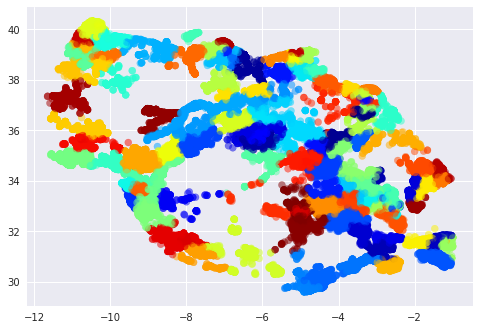

In [26]:
lga = X_pumps.lga.astype('category')

plt.scatter(x=X_pumps.latitude, y=X_pumps.longitude, 
           c=lga.cat.codes, cmap='jet', alpha=0.5);

## Ward
* No missing values
* 2000+ unique values
* Almost all values used more than once

In [181]:
X_combined.ward.isnull().sum()

0

In [182]:
len(X_combined.ward.unique())

2098

In [184]:
(X_combined.ward.value_counts() == 1).sum()

21

In [183]:
print(X_combined.ward.value_counts().head())
print('\n')
print(X_combined.ward.value_counts().tail())

Igosi        386
Imalinyi     318
Siha Kati    297
Mdandu       292
Nduruma      261
Name: ward, dtype: int64


Ikweha             1
Mwamashimba        1
Uwanja wa Ndege    1
Nyamtinga          1
Kihangimahuka      1
Name: ward, dtype: int64


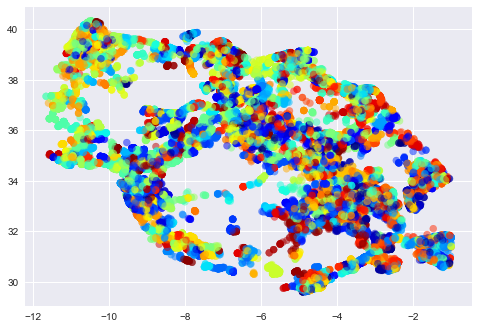

In [48]:
ward = X_pumps.ward.astype('category')

plt.scatter(x=X_pumps.latitude, y=X_pumps.longitude, 
           c=ward.cat.codes, cmap='jet', alpha=0.5);

## Subvillage
* 400+ missing values
* 21000+ unique values
* 9000+ values only used once

In [135]:
X_combined.subvillage.isnull().sum()

470

In [133]:
len(X_combined.subvillage.unique())

21426

In [134]:
(X_combined.subvillage.value_counts() == 1).sum()

9752

In [160]:
X_combined.subvillage.value_counts(dropna=False).head(10)

Shuleni     646
Majengo     631
Madukani    629
NaN         470
Kati        467
Mtakuja     322
Sokoni      294
M           243
Muungano    215
Mbuyuni     210
Name: subvillage, dtype: int64

## GPS Height
* Thousands of pumps with a gps_height = 0. 
* Four regions have only gps_height = 0. 
* Many of these likely represent missing values. 

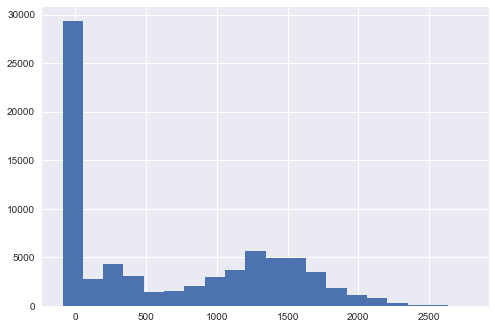

In [82]:
X_combined.gps_height.hist(bins=20)

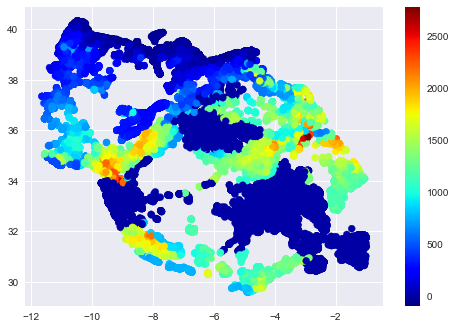

In [83]:
plt.scatter(x=X_combined.latitude, y=X_combined.longitude, 
            c=X_combined.gps_height, cmap='jet')
plt.colorbar();

In [84]:
g = X_combined.groupby(['region']).gps_height.agg(['min', 'mean', 'max', 'std'])
g[g == 0].dropna()

,min,mean,max,std
region,,,,
Dodoma,0.0,0.0,0.0,0.0
Kagera,0.0,0.0,0.0,0.0
Mbeya,0.0,0.0,0.0,0.0
Tabora,0.0,0.0,0.0,0.0


## Population
* 26000+ pumps with population = 0.
* Four regions have only population = 0 (same ones as gps_height).  
* Most of these population values are likely missing values.

In [85]:
X_combined.population.value_counts().head()

0      26834
1       8782
200     2370
150     2328
250     2087
Name: population, dtype: int64

In [86]:
p = X_combined.groupby(['region']).population.agg(['min', 'mean', 'max', 'std'])
p[p == 0].dropna()

,min,mean,max,std
region,,,,
Dodoma,0.0,0.0,0.0,0.0
Kagera,0.0,0.0,0.0,0.0
Mbeya,0.0,0.0,0.0,0.0
Tabora,0.0,0.0,0.0,0.0


In [87]:
X_combined[X_combined.population == 0].groupby('region').size()

region
Arusha            1
Dodoma         2779
Iringa         1453
Kagera         4174
Kigoma           40
Kilimanjaro       1
Mbeya          5758
Mwanza         3426
Pwani             1
Rukwa            64
Ruvuma          593
Shinyanga      6076
Singida           2
Tabora         2466
dtype: int64

## Amount TSH
* Amount water available to waterpoint
* 52000+ pumps with amount_tsh = 0.
* Four regions have only amount_tsh = 0 (same ones as other features).  
* Most of these amount_tsh values are likely missing values.

In [88]:
X_combined.amount_tsh.value_counts().head()

0.0       52049
500.0      3874
50.0       3103
1000.0     1858
20.0       1812
Name: amount_tsh, dtype: int64

In [89]:
a = X_combined.groupby(['region']).amount_tsh.agg(['min', 'mean', 'max', 'std'])
a[a == 0].dropna()

,min,mean,max,std
region,,,,
Dodoma,0.0,0.0,0.0,0.0
Kagera,0.0,0.0,0.0,0.0
Mbeya,0.0,0.0,0.0,0.0
Tabora,0.0,0.0,0.0,0.0


## Construction Year
* 25000+ pumps with construction_year = 0.
* Four regions have only construction_year = 0 (same ones as other features).  
* Other regions also have high numbers of construction_year = 0 (e.g. Shinyanga, Mwanza)
* All of these construction_year values are obviously missing values.

In [98]:
X_combined.construction_year.value_counts().head()

0       25969
2010     3314
2008     3243
2009     3196
2000     2578
Name: construction_year, dtype: int64

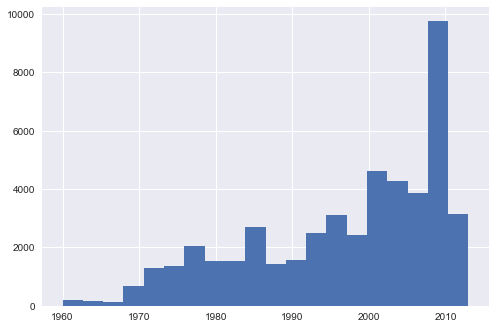

In [91]:
c = X_combined.construction_year
c[c > 0].hist(bins=20);

In [92]:
p = X_combined.groupby(['region']).construction_year.agg(['min', 'mean', 'max', 'std'])
p[p == 0].dropna()

,min,mean,max,std
region,,,,
Dodoma,0,0.0,0.0,0.0
Kagera,0,0.0,0.0,0.0
Mbeya,0,0.0,0.0,0.0
Tabora,0,0.0,0.0,0.0


In [93]:
X_combined[X_combined.construction_year == 0].groupby('region').size()

region
Arusha             60
Dar es Salaam      20
Dodoma           2779
Iringa            470
Kagera           4174
Kigoma             11
Kilimanjaro        38
Lindi             136
Manyara            16
Mara               20
Mbeya            5758
Morogoro           24
Mtwara            104
Mwanza           3441
Pwani             225
Rukwa               2
Ruvuma             20
Shinyanga        6076
Singida            11
Tabora           2466
Tanga             118
dtype: int64

## Date Recorded
* Almost all information was recorded between 2011-2013
* No missing values

In [94]:
X_combined.date_recorded = pd.to_datetime(X_combined.date_recorded)
X_combined.date_recorded.dt.year.value_counts(dropna=False).sort_index()

2001        1
2002        1
2004       41
2011    35908
2012     8089
2013    30210
Name: date_recorded, dtype: int64

## Funder
* 4500+ missing values
* 900+ values = 0
* 2100+ unique  values
* 1100+ values only used once
* Large disparity in value usage between least used (1) and most used (11000+)

In [99]:
X_combined.funder.value_counts(dropna=False).head()

Government Of Tanzania    11299
NaN                        4504
Danida                     3907
Hesawa                     2782
Rwssp                      1703
Name: funder, dtype: int64

In [101]:
X_combined.funder.value_counts(dropna=False).sort_index().head()

0               980
A/co Germany     19
Aar              41
Abas Ka           1
Abasia           51
Name: funder, dtype: int64

In [102]:
len(X_combined.funder.unique())

2141

In [103]:
(X_combined.funder.value_counts() == 1).sum()

1129

## Installer
* Values are lowercase, mixed case, uppercase
* 4500+ missing values
* 900+ values = 0
* 2100+ unique values
* 1000+ values only used once
* Large disparity in value usage between least used (1) and most used (21000+)

In [104]:
X_combined.installer = X_combined.installer.str.upper()
X_combined.installer.value_counts(dropna=False).head()

DWE           21756
NaN            4532
GOVERNMENT     2367
HESAWA         1768
RWE            1498
Name: installer, dtype: int64

In [105]:
X_combined.installer.value_counts(dropna=False).sort_index().head()

-            3
0          980
A.D.B        1
AAR          5
AARTISA      1
Name: installer, dtype: int64

In [106]:
len(X_combined.installer.unique())

2163

In [107]:
(X_combined.installer.value_counts() == 1).sum()

1095

## WPT Name
* 4400+ values = 'none'
* 45000+ unique values
* 39000+ values only used once
* Not likely a useful feature for classifying water pumps

In [122]:
X_combined.wpt_name.value_counts(dropna=False).head(10)

none               4440
Shuleni            2183
Zahanati           1034
Msikitini           647
Kanisani            390
Sokoni              328
Bombani             323
Ofisini             321
School              260
Shule Ya Msingi     247
Name: wpt_name, dtype: int64

In [112]:
len(X_combined.wpt_name.unique())

45684

In [113]:
(X_combined.wpt_name.value_counts() == 1).sum()

39882

## Public Meeting
* 4100+ missing values

In [248]:
X_combined.public_meeting.value_counts(dropna=False)

True     63749
False     6346
NaN       4155
Name: public_meeting, dtype: int64

## Recorded By
* No missing values
* Every record has same value

In [185]:
X_combined.recorded_by.value_counts(dropna=False)

GeoData Consultants Ltd    74250
Name: recorded_by, dtype: int64

## Scheme Management
* 4800+ missing values
* 12 unique values
* 66% of the records use the same value (VWC)

In [281]:
X_combined.scheme_management.isnull().sum()

4846

In [285]:
X_combined.scheme_management.value_counts(normalize=True)

VWC                 0.661590
WUG                 0.093597
Water authority     0.057273
WUA                 0.051164
Water Board         0.049882
Parastatal          0.030603
Company             0.019322
Private operator    0.019106
Other               0.014351
SWC                 0.001772
Trust               0.001326
None                0.000014
Name: scheme_management, dtype: float64

## Scheme Name
* Values are lowercase, mixed, uppercase
* 35000+ missing values
* 2700+ unique values
* 600+ values only used once

In [287]:
X_combined.scheme_name.isnull().sum()

35258

In [295]:
len(X_combined.scheme_name.str.upper().unique())

2723

In [309]:
(X_combined.scheme_name.str.upper().value_counts() == 1).sum()

656

In [299]:
X_combined.scheme_name.str.upper().value_counts().head(10)

K                              861
NONE                           828
BOREHOLE                       704
CHALINZE WATE                  502
M                              490
DANIDA                         483
GOVERNMENT                     395
BAGAMOYO WATE                  384
NGANA WATER SUPPLIED SCHEME    335
WANGING'OMBE WATER SUPPLY S    323
Name: scheme_name, dtype: int64

## Permit (waterpoint is allowed)
* 3000+ missing values

In [311]:
X_combined.permit.value_counts(dropna=False)

True     48606
False    21851
NaN       3793
Name: permit, dtype: int64

# Extraction Type features appear to fall into the following hierarchy
* extraction_type_class
* extraction_type_group
* extraction_type

In [393]:
X_combined.groupby(['extraction_type_class', 
                    'extraction_type_group', 
                    'extraction_type']).size()

extraction_type_class  extraction_type_group  extraction_type          
gravity                gravity                gravity                      33263
handpump               afridev                afridev                       2208
                       india mark ii          india mark ii                 3029
                       india mark iii         india mark iii                 135
                       nira/tanira            nira/tanira                  10205
                       other handpump         other - mkulima/shinyanga        2
                                              other - play pump              101
                                              other - swn 81                 284
                                              walimi                          60
                       swn 80                 swn 80                        4588
motorpump              mono                   mono                          3628
                       other motorpum

## Extraction Type Class
* No missing values
* 7 unique values

In [313]:
X_combined.extraction_type_class.isnull().sum()

0

In [315]:
X_combined.extraction_type_class.value_counts()

gravity         33263
handpump        20612
other            8102
submersible      7772
motorpump        3777
rope pump         572
wind-powered      152
Name: extraction_type_class, dtype: int64

## Extraction Type Group
* No missing values
* 13 unique values
* subtype of extraction_type_class

In [318]:
X_combined.extraction_type_group.isnull().sum()

0

In [317]:
X_combined.extraction_type_group.value_counts().sort_index()

afridev             2208
gravity            33263
india mark ii       3029
india mark iii       135
mono                3628
nira/tanira        10205
other               8102
other handpump       447
other motorpump      149
rope pump            572
submersible         7772
swn 80              4588
wind-powered         152
Name: extraction_type_group, dtype: int64

## Extraction Type
* No missing values
* 18 unique values
* subtype of extraction_type_group

In [319]:
X_combined.extraction_type.isnull().sum()

0

In [320]:
X_combined.extraction_type.value_counts().sort_index()

afridev                       2208
cemo                           108
climax                          41
gravity                      33263
india mark ii                 3029
india mark iii                 135
ksb                           1790
mono                          3628
nira/tanira                  10205
other                         8102
other - mkulima/shinyanga        2
other - play pump              101
other - rope pump              572
other - swn 81                 284
submersible                   5982
swn 80                        4588
walimi                          60
windmill                       152
Name: extraction_type, dtype: int64

## Management Group
* 600+ missing values (unknown)

In [324]:
X_combined.management_group.isnull().sum()

0

In [325]:
X_combined.management_group.value_counts()

user-group    65538
commercial     4591
parastatal     2229
other          1209
unknown         683
Name: management_group, dtype: int64

## Management
* 600+ missing values (unknown)
* 11 unique values
* 68% of the records use the same value (VWC)
* subtype of management_group

In [326]:
X_combined.management.isnull().sum()

0

In [328]:
X_combined.management.value_counts(normalize=True)

vwc                 0.681805
wug                 0.109199
water board         0.049670
wua                 0.041993
private operator    0.033724
parastatal          0.030020
water authority     0.015125
other               0.014586
company             0.011569
unknown             0.009199
other - school      0.001697
trust               0.001414
Name: management, dtype: float64

## Payment Type
* 10000+ missing values (unknown)
* 6 unique values

In [361]:
X_combined.payment_type.isnull().sum()

0

In [364]:
X_combined.payment_type.value_counts()

never pay     31712
per bucket    11266
monthly       10397
unknown       10149
on failure     4842
annually       4570
other          1314
Name: payment_type, dtype: int64

## Payment
* Duplicate feature of Payment Type ("on failure" = "pay when scheme fails")

In [365]:
X_combined.payment.isnull().sum()

0

In [369]:
X_combined.payment.value_counts()

never pay                31712
pay per bucket           11266
pay monthly              10397
unknown                  10149
pay when scheme fails     4842
pay annually              4570
other                     1314
Name: payment, dtype: int64

In [394]:
X_combined.groupby(['payment_type', 'payment']).size()

payment_type  payment              
annually      pay annually              4570
monthly       pay monthly              10397
never pay     never pay                31712
on failure    pay when scheme fails     4842
other         other                     1314
per bucket    pay per bucket           11266
unknown       unknown                  10149
dtype: int64

## Quality Group
* 2000+ missing values (unknown)
* 5 unique values
* 85% of the records use the same value (soft)

In [374]:
X_combined.quality_group.value_counts()

good        63505
salty        6505
unknown      2345
milky        1005
colored       623
fluoride      267
Name: quality_group, dtype: int64

In [375]:
X_combined.quality_group.value_counts(normalize=True)

good        0.855286
salty       0.087609
unknown     0.031582
milky       0.013535
colored     0.008391
fluoride    0.003596
Name: quality_group, dtype: float64

## Water Quality
* 2000+ missing values (unknown)
* 7 unique values
* 85% of the records use the same value (soft)
* subtype of quality_group

In [367]:
X_combined.water_quality.isnull().sum()

0

In [372]:
X_combined.water_quality.value_counts()

soft                  63505
salty                  6082
unknown                2345
milky                  1005
coloured                623
salty abandoned         423
fluoride                244
fluoride abandoned       23
Name: water_quality, dtype: int64

In [373]:
X_combined.water_quality.value_counts(normalize=True)

soft                  0.855286
salty                 0.081912
unknown               0.031582
milky                 0.013535
coloured              0.008391
salty abandoned       0.005697
fluoride              0.003286
fluoride abandoned    0.000310
Name: water_quality, dtype: float64

In [390]:
X_combined.groupby(['quality_group', 'water_quality']).size()

quality_group  water_quality     
colored        coloured                623
fluoride       fluoride                244
               fluoride abandoned       23
good           soft                  63505
milky          milky                  1005
salty          salty                  6082
               salty abandoned         423
unknown        unknown                2345
dtype: int64

## Quantity
* 900+ missing values (unknown)
* 4 unique values

In [377]:
X_combined.quantity.value_counts()

enough          41522
insufficient    18896
dry              7782
seasonal         5075
unknown           975
Name: quantity, dtype: int64

## Quantity Group
* Duplicate feature of Quantity

In [379]:
X_combined.quantity_group.value_counts()

enough          41522
insufficient    18896
dry              7782
seasonal         5075
unknown           975
Name: quantity_group, dtype: int64

In [473]:
X_combined.groupby(['quantity', 'quantity_group']).size()

quantity      quantity_group
dry           dry                7782
enough        enough            41522
insufficient  insufficient      18896
seasonal      seasonal           5075
unknown       unknown             975
dtype: int64

# Source features appear to fall into the following hierarachy
* source_class
* source_type
* source

In [388]:
X_combined.groupby(['source_class', 'source_type', 'source']).size()

source_class  source_type           source              
groundwater   borehole              hand dtw                 1108
                                    machine dbh             13822
              shallow well          shallow well            21140
              spring                spring                  21216
surface       dam                   dam                       840
              rainwater harvesting  rainwater harvesting     2863
              river/lake            lake                      950
                                    river                   11964
unknown       other                 other                     261
                                    unknown                    86
dtype: int64

## Source Class
* 300+ missing values (unknown)
* 2 unique values

In [383]:
X_combined.source_class.value_counts()

groundwater    57286
surface        16617
unknown          347
Name: source_class, dtype: int64

## Source Type
* No missing values
* 7 unique values

In [387]:
X_combined.source_type.value_counts()

spring                  21216
shallow well            21140
borehole                14930
river/lake              12914
rainwater harvesting     2863
dam                       840
other                     347
Name: source_type, dtype: int64

## Source
* 80+ missing values (unknown)
* 9 unique values
* unknown and other appear to be the same value

In [381]:
X_combined.source.value_counts()

spring                  21216
shallow well            21140
machine dbh             13822
river                   11964
rainwater harvesting     2863
hand dtw                 1108
lake                      950
dam                       840
other                     261
unknown                    86
Name: source, dtype: int64

## Waterpoint Type Group
* No missing values
* 6 unique values

In [396]:
X_combined.waterpoint_type_group.value_counts()

communal standpipe    43239
hand pump             21884
other                  8010
improved spring         959
cattle trough           150
dam                       8
Name: waterpoint_type_group, dtype: int64

## Waterpoint Type
* No missing values
* 7 unique values
* subtype of waterpoint_type_group

In [398]:
X_combined.waterpoint_type.value_counts()

communal standpipe             35628
hand pump                      21884
other                           8010
communal standpipe multiple     7611
improved spring                  959
cattle trough                    150
dam                                8
Name: waterpoint_type, dtype: int64

## Combine the features and labels into one dataset

In [414]:
Xy_pumps = pd.merge(y_pumps, X_pumps, how='inner', left_index=True, right_index=True)
Xy_pumps['id'] = Xy_pumps.id_x
Xy_pumps.set_index('id', inplace=True)
Xy_pumps.drop(['id_x', 'id_y'], axis=1, inplace=True)
Xy_pumps.status_group = Xy_pumps.status_group.astype('category').cat.codes
Xy_pumps.head()

,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,dataset
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,0,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,0
8776,0,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0
34310,0,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,0
67743,2,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,0
19728,0,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0


## Transform features into numeric datatypes

In [415]:
def boolean_to_int(feature):
    most_common = Xy_pumps[feature].value_counts().idxmax()
    boolean = Xy_pumps[feature].fillna(most_common).astype(int)
    Xy_pumps[feature + '_int'] = boolean

In [416]:
def category_to_code(feature):
    category = Xy_pumps[feature].astype('category')
    Xy_pumps[feature + '_codes'] = category.cat.codes

In [417]:
boolean_to_int('public_meeting')
boolean_to_int('permit')
category_to_code('funder')
category_to_code('installer')
category_to_code('wpt_name')
category_to_code('basin')
category_to_code('subvillage')
category_to_code('region')
category_to_code('lga')
category_to_code('ward')
category_to_code('scheme_management')
category_to_code('scheme_name')
category_to_code('extraction_type')
category_to_code('extraction_type_group')
category_to_code('extraction_type_class')
category_to_code('management')
category_to_code('management_group')
category_to_code('payment')
category_to_code('payment_type')
category_to_code('water_quality')
category_to_code('quality_group')
category_to_code('quantity')
category_to_code('quantity_group')
category_to_code('source')
category_to_code('source_type')
category_to_code('source_class')
category_to_code('waterpoint_type')
category_to_code('waterpoint_type_group')

## Which features are strongly correlated with status_group (i.e. label)?

In [421]:
c = Xy_pumps.drop('dataset', axis=1.corr()
c.status_group.abs().sort_values(ascending=False)

status_group                   1.000000
waterpoint_type_codes          0.206507
waterpoint_type_group_codes    0.206431
extraction_type_class_codes    0.175338
quality_group_codes            0.153163
quantity_group_codes           0.131425
quantity_codes                 0.131425
gps_height                     0.114029
extraction_type_group_codes    0.111497
region_code                    0.108640
extraction_type_codes          0.107827
source_codes                   0.097617
region_codes                   0.091252
source_type_codes              0.079656
payment_codes                  0.076992
public_meeting_int             0.067965
district_code                  0.065687
lga_codes                      0.065302
management_codes               0.060587
scheme_management_codes        0.057009
payment_type_codes             0.055772
amount_tsh                     0.053702
funder_codes                   0.048350
basin_codes                    0.043413
construction_year              0.043342
